# Demo 2: Pivot Tables and Cross-Tabulations

## Learning Objectives
- Create pivot tables for multi-dimensional analysis
- Use cross-tabulations for frequency analysis
- Apply advanced pivot operations
- Handle missing values and totals

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set inline plotting for Jupyter
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Basic Pivot Tables

### Create Sample Data

In [2]:
# Create large-scale sales dataset (100,000 transactions)
print("=== Creating Large-Scale Sales Dataset ===")
np.random.seed(42)
n_transactions = 100000

# Generate realistic sales data
products = [
    "Electronics",
    "Clothing",
    "Books",
    "Home",
    "Sports",
    "Toys",
    "Food",
    "Beauty",
]
regions = ["North", "South", "East", "West", "Central"]
categories = ["Premium", "Standard", "Budget"]
sales_channels = ["Online", "Retail", "Wholesale"]

# Product-specific pricing
product_base_prices = {
    "Electronics": (200, 2000),
    "Clothing": (30, 400),
    "Books": (15, 60),
    "Home": (50, 900),
    "Sports": (40, 600),
    "Toys": (20, 250),
    "Food": (5, 50),
    "Beauty": (10, 150),
}

# Generate data
transactions = []
for i in range(n_transactions):
    product = np.random.choice(products)
    region = np.random.choice(regions)
    category = np.random.choice(categories)
    channel = np.random.choice(sales_channels)

    # Correlated pricing: Premium > Standard > Budget
    price_multiplier = {"Premium": 1.5, "Standard": 1.0, "Budget": 0.7}[
        category
    ]
    price_min, price_max = product_base_prices[product]
    unit_price = np.random.uniform(price_min, price_max) * price_multiplier

    # Quantity inversely correlated with price
    quantity = max(
        1,
        int(
            np.random.exponential(5)
            * (1 - (unit_price - price_min) / (price_max * 1.5 - price_min))
        ),
    )
    quantity = min(quantity, 50)

    sales = unit_price * quantity

    # Add seasonal variation
    month = np.random.randint(1, 13)
    seasonal_mult = 1.0 + 0.3 * np.sin(
        2 * np.pi * month / 12
    )  # Seasonal pattern
    sales *= seasonal_mult

    transactions.append({
        "Product": product,
        "Region": region,
        "Category": category,
        "Channel": channel,
        "Unit_Price": round(unit_price, 2),
        "Quantity": quantity,
        "Sales": round(sales, 2),
        "Month": month,
    })

df = pd.DataFrame(transactions)
df["Date"] = pd.date_range("2020-01-01", periods=n_transactions, freq="H")[
    :n_transactions
]
df["Quarter"] = df["Date"].dt.quarter
df["Year"] = df["Date"].dt.year

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nSample Data:")
print(df.head(10))
print("\nBasic Statistics:")
print(df.describe())

=== Creating Large-Scale Sales Dataset ===


Dataset shape: (100000, 11)
Memory usage: 34.81 MB

Sample Data:
       Product   Region  Category    Channel  Unit_Price  Quantity    Sales  \
0         Food     West   Premium  Wholesale       56.91         1    48.37   
1     Clothing     East    Budget  Wholesale      139.95         1   103.59   
2       Beauty     East  Standard     Online      145.79         3   437.36   
3     Clothing     West   Premium     Online      213.85         2   427.71   
4  Electronics    North    Budget  Wholesale      643.82         1   643.82   
5       Beauty     East    Budget     Online       11.55         4    53.14   
6  Electronics    South   Premium     Retail     2482.67         1  2855.07   
7     Clothing     West    Budget  Wholesale      178.99         6  1396.12   
8         Toys    North  Standard     Retail      117.79         1   148.39   
9         Toys  Central    Budget     Retail      138.80         9  1573.71   

   Month                Date  Quarter  Year  
0      7 2020-01-01

/var/folders/43/0jfkbfr53g1_nbv1ymsqgfl40000gp/T/ipykernel_49674/520265495.py:79: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["Date"] = pd.date_range("2020-01-01", periods=n_transactions, freq="H")[


### Basic Pivot Table

=== Basic Pivot Table: Sales by Product and Region ===
Sales by Product and Region:
Region          Central        East       North       South        West
Product                                                                
Beauty        525916.25   509666.23   539209.43   532627.74   532420.83
Books         267263.61   258409.81   263170.91   272640.31   267918.07
Clothing     1407194.82  1454631.15  1428987.11  1454926.73  1474403.44
Electronics  7644269.89  6962001.12  7496996.51  6685631.56  7558668.85
Food          197504.53   188042.16   196393.60   183640.38   176141.57
Home         3180482.82  3184870.52  3006246.27  3011783.39  3134069.51
Sports       2060143.31  2066281.37  2124496.77  2063689.32  2150972.92
Toys          920184.24   899651.25   855499.48   912305.23   874402.06


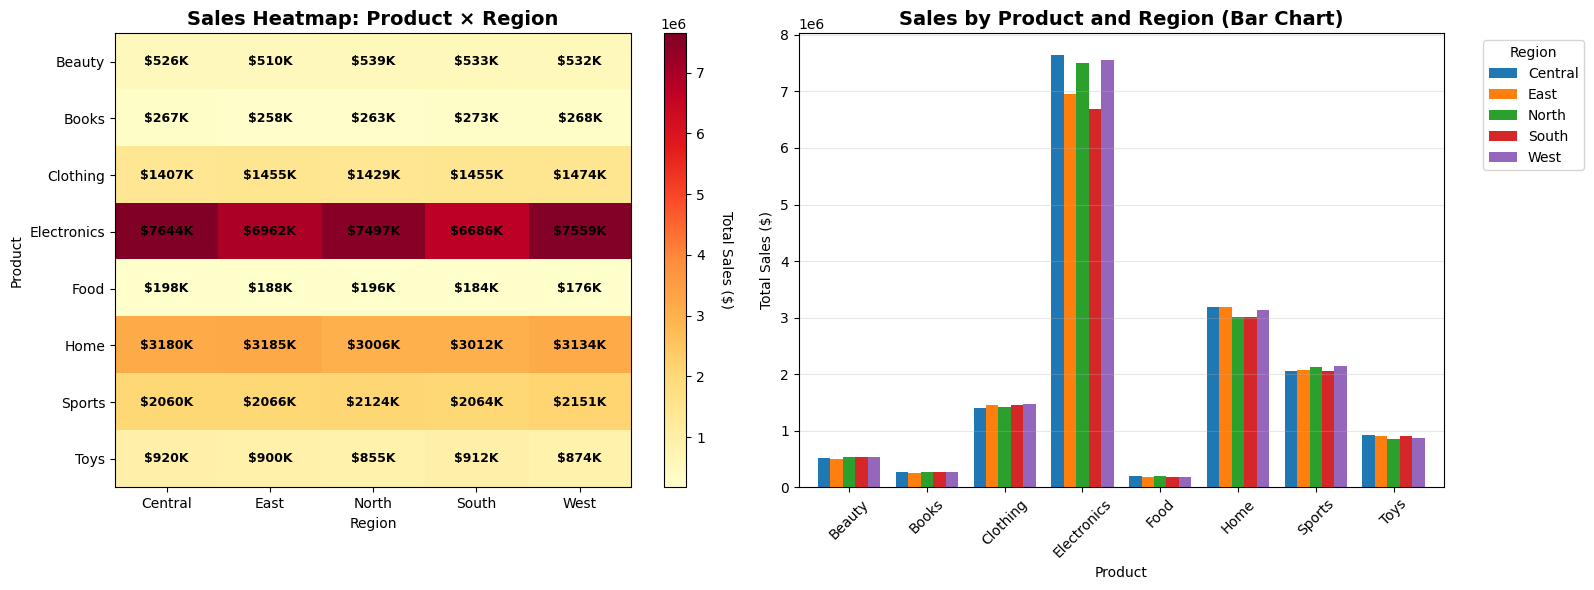

In [3]:
# Create basic pivot table
print("=== Basic Pivot Table: Sales by Product and Region ===")
pivot = pd.pivot_table(
    df, values="Sales", index="Product", columns="Region", aggfunc="sum"
)
print("Sales by Product and Region:")
print(pivot)

# Visualize basic pivot table
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Heatmap visualization
im = axes[0].imshow(pivot.values, cmap="YlOrRd", aspect="auto")
axes[0].set_xticks(range(len(pivot.columns)))
axes[0].set_yticks(range(len(pivot.index)))
axes[0].set_xticklabels(pivot.columns)
axes[0].set_yticklabels(pivot.index)
axes[0].set_title(
    "Sales Heatmap: Product × Region", fontsize=14, fontweight="bold"
)
axes[0].set_xlabel("Region")
axes[0].set_ylabel("Product")
cbar = plt.colorbar(im, ax=axes[0])
cbar.set_label("Total Sales ($)", rotation=270, labelpad=20)

# Add text annotations
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        text = axes[0].text(
            j,
            i,
            f"${pivot.iloc[i, j] / 1000:.0f}K",
            ha="center",
            va="center",
            color="black",
            fontsize=9,
            fontweight="bold",
        )

# 2. Grouped bar chart
pivot.plot(kind="bar", ax=axes[1], width=0.8)
axes[1].set_title(
    "Sales by Product and Region (Bar Chart)", fontsize=14, fontweight="bold"
)
axes[1].set_ylabel("Total Sales ($)")
axes[1].set_xlabel("Product")
axes[1].legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Pivot Table with Multiple Aggregations

=== Multiple Aggregations ===


Multiple aggregations (sum, mean, count, std):
                    sum                                                  \
Region          Central        East       North       South        West   
Product                                                                   
Beauty        525916.25   509666.23   539209.43   532627.74   532420.83   
Books         267263.61   258409.81   263170.91   272640.31   267918.07   
Clothing     1407194.82  1454631.15  1428987.11  1454926.73  1474403.44   
Electronics  7644269.89  6962001.12  7496996.51  6685631.56  7558668.85   
Food          197504.53   188042.16   196393.60   183640.38   176141.57   
Home         3180482.82  3184870.52  3006246.27  3011783.39  3134069.51   
Sports       2060143.31  2066281.37  2124496.77  2063689.32  2150972.92   
Toys          920184.24   899651.25   855499.48   912305.23   874402.06   

                    mean                                                      \
Region           Central         East        No

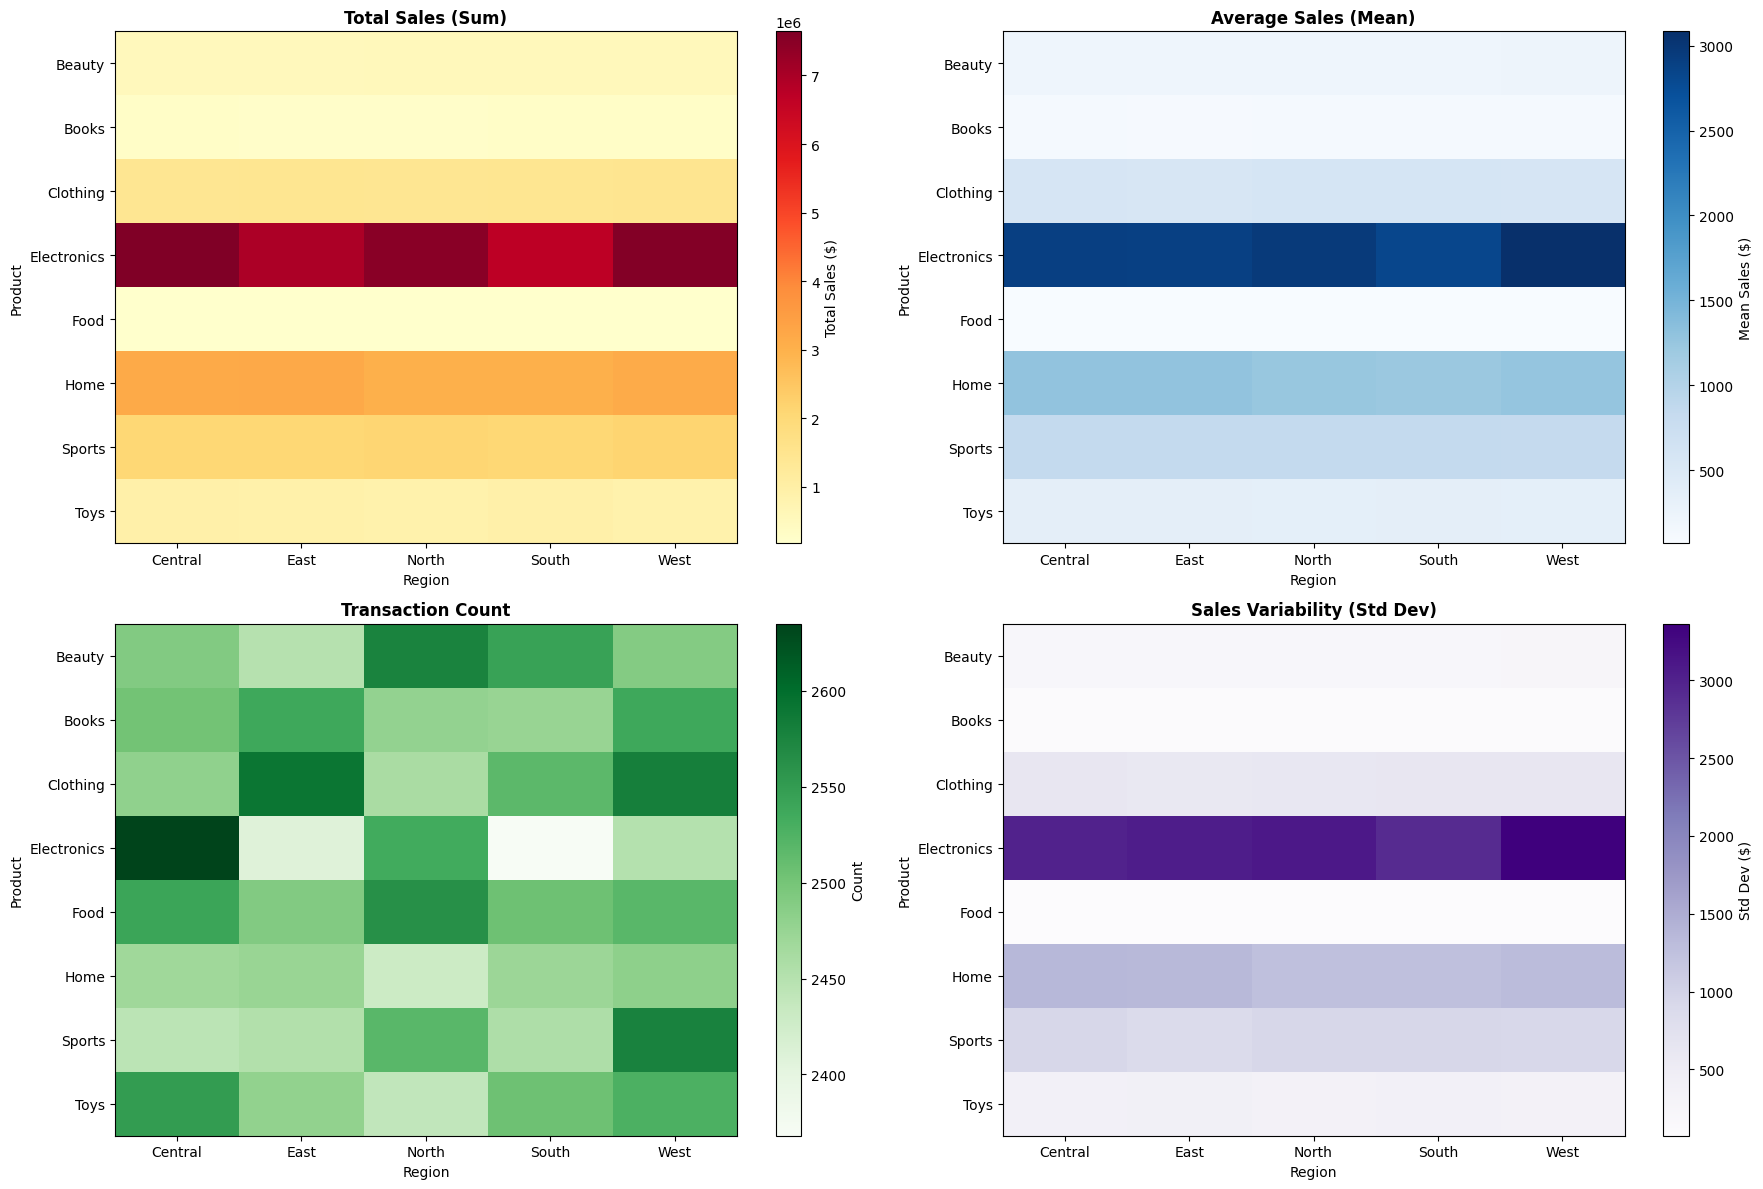

In [4]:
# Pivot table with multiple aggregations
print("=== Multiple Aggregations ===")
pivot_multi = pd.pivot_table(
    df,
    values="Sales",
    index="Product",
    columns="Region",
    aggfunc=["sum", "mean", "count", "std"],
)
print("Multiple aggregations (sum, mean, count, std):")
print(pivot_multi)

# Visualize multiple aggregations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Extract each aggregation level
pivot_sum = pivot_multi["sum"]
pivot_mean = pivot_multi["mean"]
pivot_count = pivot_multi["count"]
pivot_std = pivot_multi["std"]

# 1. Sum heatmap
im1 = axes[0, 0].imshow(pivot_sum.values, cmap="YlOrRd", aspect="auto")
axes[0, 0].set_xticks(range(len(pivot_sum.columns)))
axes[0, 0].set_yticks(range(len(pivot_sum.index)))
axes[0, 0].set_xticklabels(pivot_sum.columns)
axes[0, 0].set_yticklabels(pivot_sum.index)
axes[0, 0].set_title("Total Sales (Sum)", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Region")
axes[0, 0].set_ylabel("Product")
plt.colorbar(im1, ax=axes[0, 0], label="Total Sales ($)")

# 2. Mean heatmap
im2 = axes[0, 1].imshow(pivot_mean.values, cmap="Blues", aspect="auto")
axes[0, 1].set_xticks(range(len(pivot_mean.columns)))
axes[0, 1].set_yticks(range(len(pivot_mean.index)))
axes[0, 1].set_xticklabels(pivot_mean.columns)
axes[0, 1].set_yticklabels(pivot_mean.index)
axes[0, 1].set_title("Average Sales (Mean)", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Region")
axes[0, 1].set_ylabel("Product")
plt.colorbar(im2, ax=axes[0, 1], label="Mean Sales ($)")

# 3. Count heatmap
im3 = axes[1, 0].imshow(pivot_count.values, cmap="Greens", aspect="auto")
axes[1, 0].set_xticks(range(len(pivot_count.columns)))
axes[1, 0].set_yticks(range(len(pivot_count.index)))
axes[1, 0].set_xticklabels(pivot_count.columns)
axes[1, 0].set_yticklabels(pivot_count.index)
axes[1, 0].set_title("Transaction Count", fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("Region")
axes[1, 0].set_ylabel("Product")
plt.colorbar(im3, ax=axes[1, 0], label="Count")

# 4. Standard deviation heatmap (shows variability)
im4 = axes[1, 1].imshow(pivot_std.values, cmap="Purples", aspect="auto")
axes[1, 1].set_xticks(range(len(pivot_std.columns)))
axes[1, 1].set_yticks(range(len(pivot_std.index)))
axes[1, 1].set_xticklabels(pivot_std.columns)
axes[1, 1].set_yticklabels(pivot_std.index)
axes[1, 1].set_title(
    "Sales Variability (Std Dev)", fontsize=12, fontweight="bold"
)
axes[1, 1].set_xlabel("Region")
axes[1, 1].set_ylabel("Product")
plt.colorbar(im4, ax=axes[1, 1], label="Std Dev ($)")

plt.tight_layout()
plt.show()

## Part 2: Advanced Pivot Operations

### Pivot Table with Totals

In [5]:
# Pivot table with totals
print("=== Pivot Table with Totals ===")
pivot_totals = pd.pivot_table(
    df,
    values="Sales",
    index="Product",
    columns="Region",
    aggfunc="sum",
    margins=True,
    margins_name="Total",
)
print("Sales with totals:")
print(pivot_totals)

=== Pivot Table with Totals ===
Sales with totals:
Region           Central         East        North        South         West  \
Product                                                                        
Beauty         525916.25    509666.23    539209.43    532627.74    532420.83   
Books          267263.61    258409.81    263170.91    272640.31    267918.07   
Clothing      1407194.82   1454631.15   1428987.11   1454926.73   1474403.44   
Electronics   7644269.89   6962001.12   7496996.51   6685631.56   7558668.85   
Food           197504.53    188042.16    196393.60    183640.38    176141.57   
Home          3180482.82   3184870.52   3006246.27   3011783.39   3134069.51   
Sports        2060143.31   2066281.37   2124496.77   2063689.32   2150972.92   
Toys           920184.24    899651.25    855499.48    912305.23    874402.06   
Total        16202959.47  15523553.61  15911000.08  15117244.66  16168997.25   

Region             Total  
Product                   
Beauty        

### Handling Missing Values

In [6]:
# Create data with missing combinations
data_missing = {
    "Product": ["A", "A", "B", "B", "C"],
    "Region": ["North", "South", "North", "South", "North"],
    "Sales": [1000, 1500, 2000, 1200, 800],
}

df_missing = pd.DataFrame(data_missing)
print("=== Handling Missing Values ===")
print("Data with missing combinations:")
print(df_missing)

# Pivot with fill_value
pivot_filled = pd.pivot_table(
    df_missing,
    values="Sales",
    index="Product",
    columns="Region",
    aggfunc="sum",
    fill_value=0,
)
print("\nPivot with filled missing values:")
print(pivot_filled)

=== Handling Missing Values ===
Data with missing combinations:
  Product Region  Sales
0       A  North   1000
1       A  South   1500
2       B  North   2000
3       B  South   1200
4       C  North    800

Pivot with filled missing values:
Region   North  South
Product              
A         1000   1500
B         2000   1200
C          800      0


### Cross-Tabulation

=== Creating Large-Scale Categorical Dataset ===


Dataset shape: (100000, 5)

Sample categorical data:
  Gender Age_Group    Education Income_Level  Purchase_Amount
0      M     36-45  High School       Medium       339.183073
1      F     36-45     Bachelor          Low        15.641771
2      F     26-35  High School          Low        15.940471
3      F     36-45     Bachelor       Medium        47.543706
4      M     26-35  High School          Low        68.225169
5      M     46-55  High School       Medium       104.819443
6      M     56-65     Bachelor       Medium         7.526078
7      F     56-65          PhD         High       618.904093
8      F     26-35     Bachelor       Medium       107.268993
9      F     36-45  High School          Low        57.444120

=== Cross-Tabulation: Gender × Age Group ===
Age_Group  18-25  26-35  36-45  46-55  56-65    65+     All
Gender                                                     
F           7789  12817  10539   9404   6214   5265   52028
M           7079  12160   9447   8637  

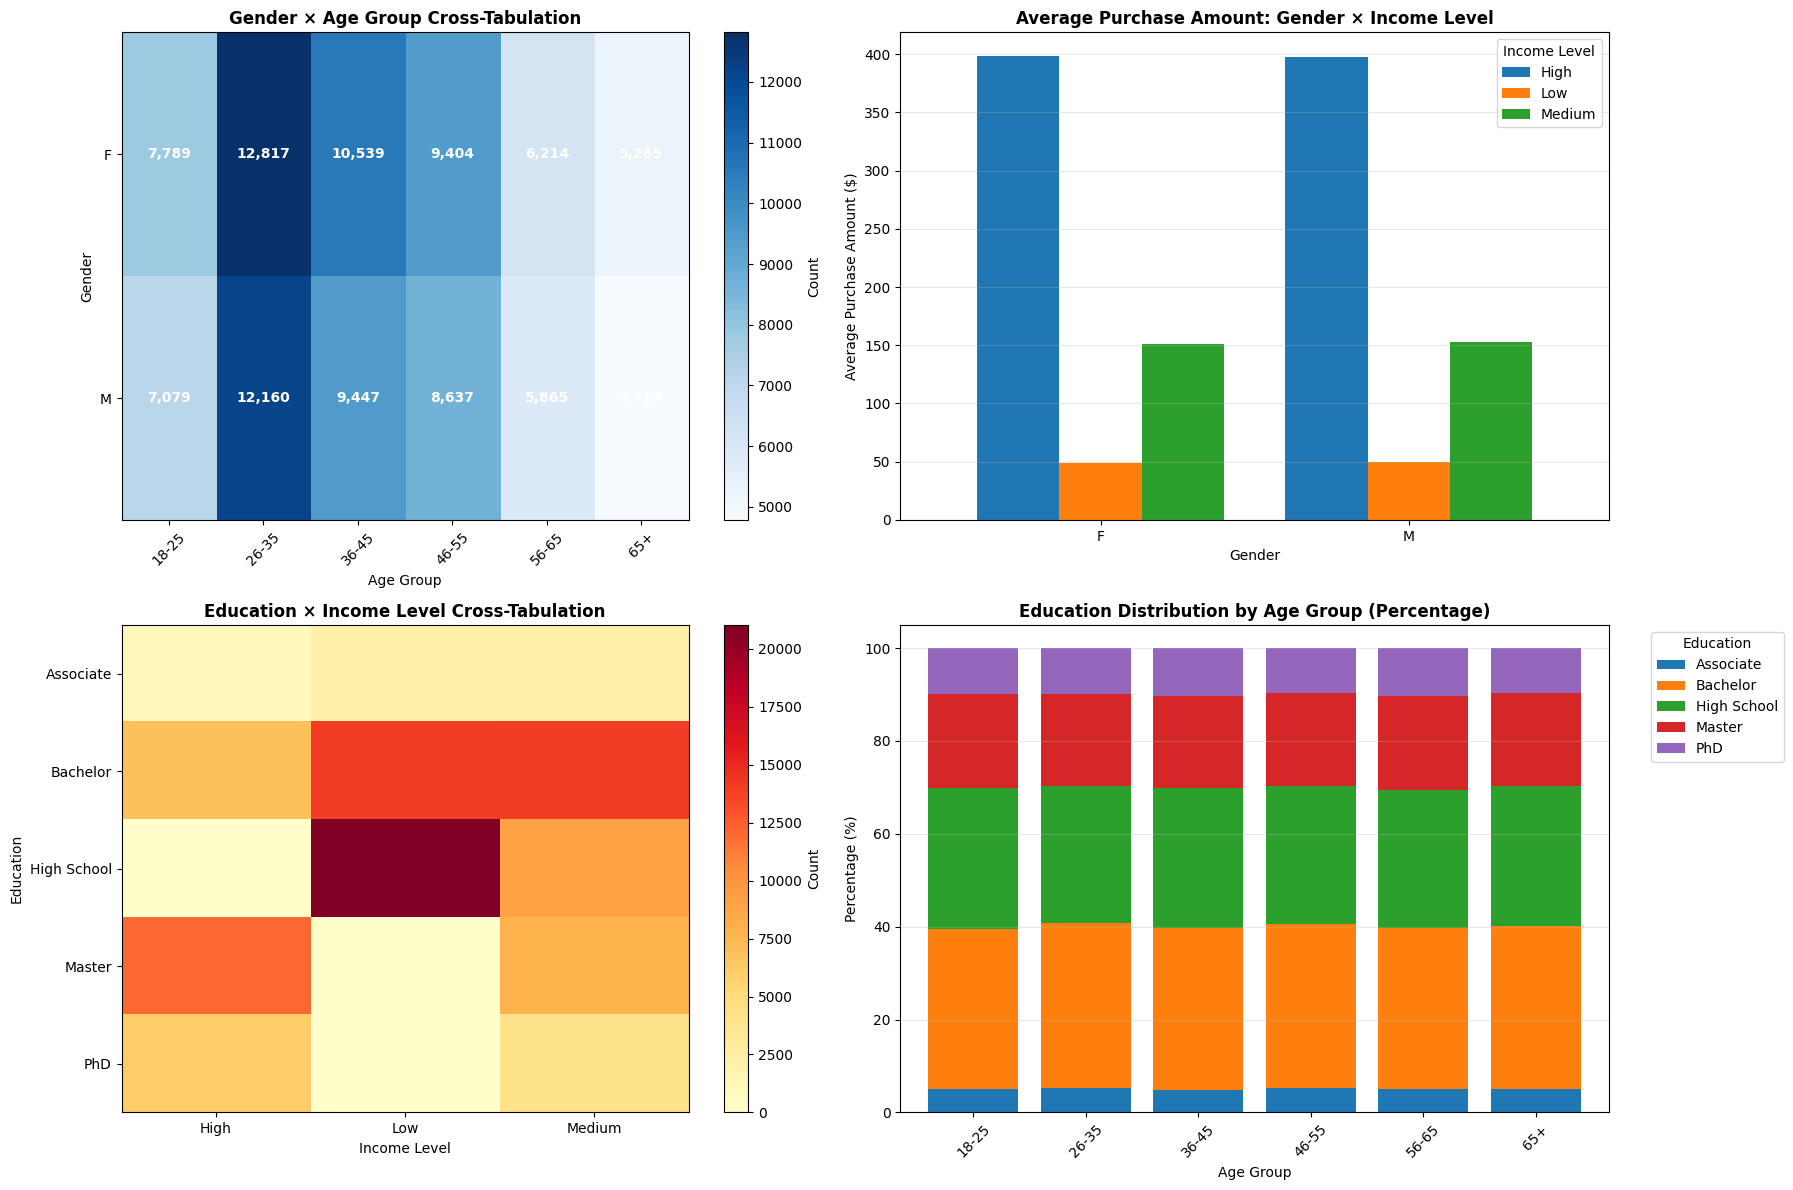

In [7]:
# Create large-scale categorical data for cross-tabulation
print("=== Creating Large-Scale Categorical Dataset ===")
np.random.seed(42)
n_observations = 100000

# Generate realistic categorical data with correlations
genders = np.random.choice(["M", "F"], n_observations, p=[0.48, 0.52])
age_groups = np.random.choice(
    ["18-25", "26-35", "36-45", "46-55", "56-65", "65+"],
    n_observations,
    p=[0.15, 0.25, 0.20, 0.18, 0.12, 0.10],
)
education_levels = np.random.choice(
    ["High School", "Bachelor", "Master", "PhD", "Associate"],
    n_observations,
    p=[0.30, 0.35, 0.20, 0.10, 0.05],
)
income_levels = np.random.choice(
    ["Low", "Medium", "High"], n_observations, p=[0.40, 0.40, 0.20]
)

# Add correlation: Higher education tends to have higher income
for i in range(n_observations):
    if education_levels[i] in ["Master", "PhD"]:
        income_levels[i] = np.random.choice(["Medium", "High"], p=[0.4, 0.6])
    elif education_levels[i] == "High School":
        income_levels[i] = np.random.choice(["Low", "Medium"], p=[0.7, 0.3])

cat_df = pd.DataFrame({
    "Gender": genders,
    "Age_Group": age_groups,
    "Education": education_levels,
    "Income_Level": income_levels,
})

# Add purchase behavior correlated with demographics
purchase_amounts = []
for i in range(n_observations):
    base = {"Low": 50, "Medium": 150, "High": 400}[income_levels[i]]
    amount = np.random.exponential(base)
    purchase_amounts.append(min(amount, 2000))

cat_df["Purchase_Amount"] = purchase_amounts

print(f"Dataset shape: {cat_df.shape}")
print("\nSample categorical data:")
print(cat_df.head(10))

# Cross-tabulation: Gender × Age Group
print("\n=== Cross-Tabulation: Gender × Age Group ===")
crosstab = pd.crosstab(cat_df["Gender"], cat_df["Age_Group"], margins=True)
print(crosstab)

# Cross-tabulation with values: Gender × Income Level (sum of purchases)
print("\n=== Cross-Tabulation with Values: Gender × Income Level ===")
crosstab_values = pd.crosstab(
    cat_df["Gender"],
    cat_df["Income_Level"],
    values=cat_df["Purchase_Amount"],
    aggfunc="sum",
    margins=True,
)
print(crosstab_values)

# Multi-dimensional cross-tabulation
print("\n=== Multi-Dimensional Cross-Tabulation ===")
crosstab_multi = pd.crosstab(
    [cat_df["Gender"], cat_df["Age_Group"]], cat_df["Education"], margins=True
)
print("Gender × Age Group × Education:")
print(crosstab_multi.head(15))

# Visualize cross-tabulations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Gender × Age Group heatmap
crosstab_no_margins = pd.crosstab(cat_df["Gender"], cat_df["Age_Group"])
im1 = axes[0, 0].imshow(crosstab_no_margins.values, cmap="Blues", aspect="auto")
axes[0, 0].set_xticks(range(len(crosstab_no_margins.columns)))
axes[0, 0].set_yticks(range(len(crosstab_no_margins.index)))
axes[0, 0].set_xticklabels(crosstab_no_margins.columns, rotation=45)
axes[0, 0].set_yticklabels(crosstab_no_margins.index)
axes[0, 0].set_title(
    "Gender × Age Group Cross-Tabulation", fontsize=12, fontweight="bold"
)
axes[0, 0].set_xlabel("Age Group")
axes[0, 0].set_ylabel("Gender")
plt.colorbar(im1, ax=axes[0, 0], label="Count")

# Add text annotations
for i in range(len(crosstab_no_margins.index)):
    for j in range(len(crosstab_no_margins.columns)):
        text = axes[0, 0].text(
            j,
            i,
            f"{crosstab_no_margins.iloc[i, j]:,}",
            ha="center",
            va="center",
            color="white",
            fontsize=10,
            fontweight="bold",
        )

# 2. Gender × Income Level (with purchase amounts)
crosstab_purchases = pd.crosstab(
    cat_df["Gender"],
    cat_df["Income_Level"],
    values=cat_df["Purchase_Amount"],
    aggfunc="mean",
)
crosstab_purchases.plot(kind="bar", ax=axes[0, 1], width=0.8)
axes[0, 1].set_title(
    "Average Purchase Amount: Gender × Income Level",
    fontsize=12,
    fontweight="bold",
)
axes[0, 1].set_ylabel("Average Purchase Amount ($)")
axes[0, 1].set_xlabel("Gender")
axes[0, 1].legend(title="Income Level")
axes[0, 1].tick_params(axis="x", rotation=0)
axes[0, 1].grid(axis="y", alpha=0.3)

# 3. Education × Income Level
edu_income = pd.crosstab(
    cat_df["Education"], cat_df["Income_Level"], margins=True
)
edu_income_no_margins = edu_income.drop("All").drop("All", axis=1)
im3 = axes[1, 0].imshow(
    edu_income_no_margins.values, cmap="YlOrRd", aspect="auto"
)
axes[1, 0].set_xticks(range(len(edu_income_no_margins.columns)))
axes[1, 0].set_yticks(range(len(edu_income_no_margins.index)))
axes[1, 0].set_xticklabels(edu_income_no_margins.columns)
axes[1, 0].set_yticklabels(edu_income_no_margins.index)
axes[1, 0].set_title(
    "Education × Income Level Cross-Tabulation", fontsize=12, fontweight="bold"
)
axes[1, 0].set_xlabel("Income Level")
axes[1, 0].set_ylabel("Education")
plt.colorbar(im3, ax=axes[1, 0], label="Count")

# 4. Age Group distribution by Education (stacked bar)
age_edu = pd.crosstab(cat_df["Age_Group"], cat_df["Education"])
age_edu_pct = age_edu.div(age_edu.sum(axis=1), axis=0) * 100
age_edu_pct.plot(kind="bar", ax=axes[1, 1], stacked=True, width=0.8)
axes[1, 1].set_title(
    "Education Distribution by Age Group (Percentage)",
    fontsize=12,
    fontweight="bold",
)
axes[1, 1].set_ylabel("Percentage (%)")
axes[1, 1].set_xlabel("Age Group")
axes[1, 1].legend(title="Education", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Real-world Analysis

### Sales Performance Analysis

In [8]:
# Use the comprehensive dataset we already created
sales_df = df.copy()
print("=== Sales Performance Analysis ===")
print(f"Using dataset with {len(sales_df):,} transactions")
print("\nSample sales data:")
print(sales_df.head())

=== Sales Performance Analysis ===
Using dataset with 100,000 transactions

Sample sales data:
       Product Region  Category    Channel  Unit_Price  Quantity   Sales  \
0         Food   West   Premium  Wholesale       56.91         1   48.37   
1     Clothing   East    Budget  Wholesale      139.95         1  103.59   
2       Beauty   East  Standard     Online      145.79         3  437.36   
3     Clothing   West   Premium     Online      213.85         2  427.71   
4  Electronics  North    Budget  Wholesale      643.82         1  643.82   

   Month                Date  Quarter  Year  
0      7 2020-01-01 00:00:00        1  2020  
1      8 2020-01-01 01:00:00        1  2020  
2      6 2020-01-01 02:00:00        1  2020  
3     12 2020-01-01 03:00:00        1  2020  
4     12 2020-01-01 04:00:00        1  2020  


### Monthly Sales by Product and Region

=== Monthly Sales by Product ===
Monthly sales by product:
Month                 1           2           3           4           5  \
Product                                                                   
Beauty        234861.71   287402.73   279128.03   264567.27   255885.08   
Books         123770.64   140090.42   144425.54   140693.29   127382.45   
Clothing      642395.82   810625.46   817392.20   789530.05   692214.08   
Electronics  3522792.23  3809071.95  3760067.78  3948589.47  3692036.65   
Food           89735.27   102817.33   106621.64    96660.78    87346.86   
Home         1540619.92  1648745.49  1627838.12  1650035.56  1437473.42   
Sports       1040001.20  1118242.62  1168058.24  1117655.81  1010622.83   
Toys          436799.74   495610.93   479681.91   440640.54   460469.85   
Total        7630976.53  8412606.93  8383213.46  8448372.77  7763431.22   

Month                 6           7           8           9          10  \
Product                                 

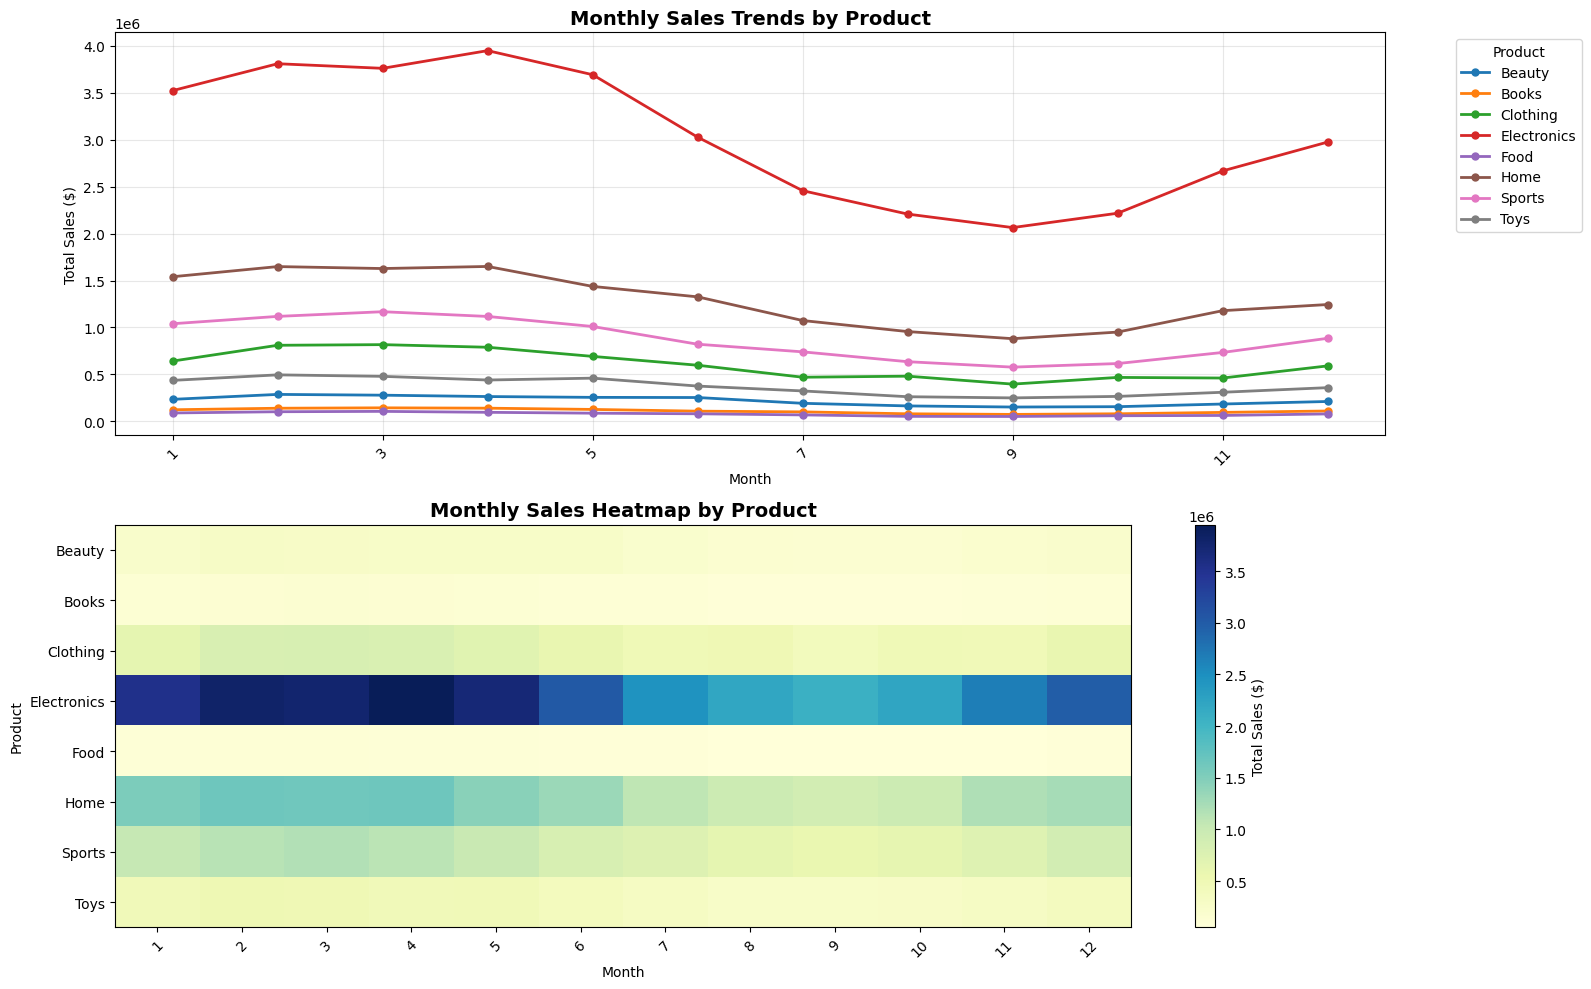

In [9]:
# Monthly sales pivot table
print("=== Monthly Sales by Product ===")
monthly_pivot = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Product",
    columns="Month",
    aggfunc="sum",
    margins=True,
    margins_name="Total",
)
print("Monthly sales by product:")
print(monthly_pivot.head(10))

# Visualize monthly trends
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 1. Monthly sales trend by product (line plot)
monthly_pivot_no_total = monthly_pivot.drop("Total", axis=1).drop(
    "Total", axis=0
)
monthly_pivot_no_total.T.plot(ax=axes[0], marker="o", linewidth=2, markersize=5)
axes[0].set_title(
    "Monthly Sales Trends by Product", fontsize=14, fontweight="bold"
)
axes[0].set_ylabel("Total Sales ($)")
axes[0].set_xlabel("Month")
axes[0].legend(title="Product", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis="x", rotation=45)

# 2. Monthly sales heatmap
monthly_pivot_no_total_values = monthly_pivot_no_total.values
im = axes[1].imshow(monthly_pivot_no_total_values, cmap="YlGnBu", aspect="auto")
axes[1].set_xticks(range(len(monthly_pivot_no_total.columns)))
axes[1].set_yticks(range(len(monthly_pivot_no_total.index)))
axes[1].set_xticklabels(monthly_pivot_no_total.columns, rotation=45)
axes[1].set_yticklabels(monthly_pivot_no_total.index)
axes[1].set_title(
    "Monthly Sales Heatmap by Product", fontsize=14, fontweight="bold"
)
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Product")
plt.colorbar(im, ax=axes[1], label="Total Sales ($)")

plt.tight_layout()
plt.show()

### Salesperson Performance Analysis

=== Multi-Dimensional Pivot Analysis ===


Sales by Product × Region × Category:
Region          Central                                East              \
Category         Budget     Premium    Standard      Budget     Premium   
Product                                                                   
Beauty        158464.77   177369.16   190082.32   149270.65   178007.72   
Books          87078.97    90833.46    89351.18    81693.33    84321.28   
Clothing      421680.30   513320.16   472194.36   454647.93   479438.05   
Electronics  2416284.98  2896552.09  2331432.82  2004162.53  2483658.86   
Food           58284.93    67788.70    71430.90    59064.31    64103.73   
Home          997570.59  1078186.33  1104725.90   937165.63  1124673.88   
Sports        610158.07   728791.72   721193.52   578863.06   755319.84   
Toys          265153.10   335913.95   319117.19   254898.18   320362.13   
Total        5014675.71  5888755.57  5299528.19  4519765.62  5489885.49   

Region                        North                          

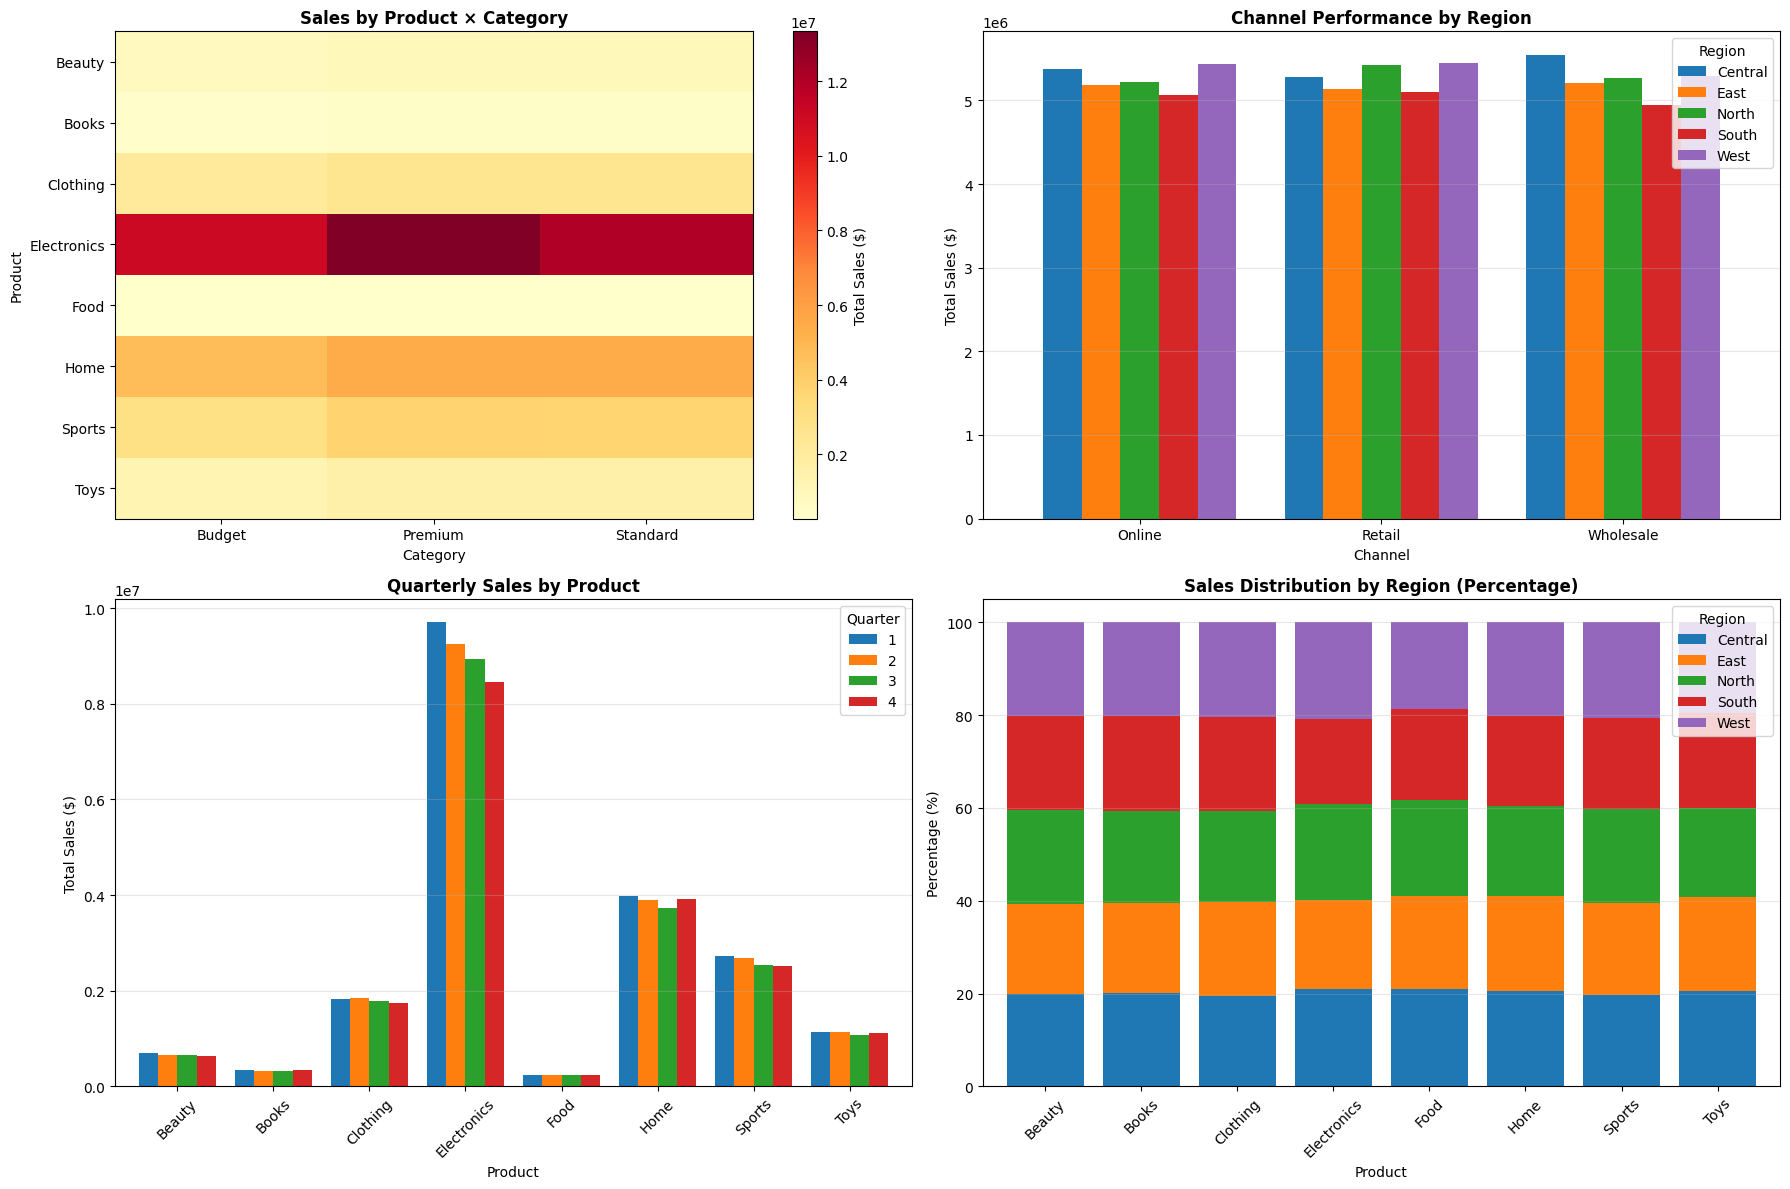

In [10]:
# Multi-dimensional pivot: Product × Region × Category
print("=== Multi-Dimensional Pivot Analysis ===")

# 1. Product × Region × Category
product_region_category = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Product",
    columns=["Region", "Category"],
    aggfunc="sum",
    margins=True,
    margins_name="Total",
)
print("Sales by Product × Region × Category:")
print(product_region_category.head(10))

# 2. Channel × Region performance
channel_region = pd.pivot_table(
    sales_df,
    values=["Sales", "Quantity"],
    index="Channel",
    columns="Region",
    aggfunc={"Sales": "sum", "Quantity": "sum"},
    margins=True,
)
print("\nChannel performance by region:")
print(channel_region)

# Visualize multi-dimensional analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Product × Category heatmap (aggregated across regions)
product_category = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Product",
    columns="Category",
    aggfunc="sum",
)
im1 = axes[0, 0].imshow(product_category.values, cmap="YlOrRd", aspect="auto")
axes[0, 0].set_xticks(range(len(product_category.columns)))
axes[0, 0].set_yticks(range(len(product_category.index)))
axes[0, 0].set_xticklabels(product_category.columns)
axes[0, 0].set_yticklabels(product_category.index)
axes[0, 0].set_title(
    "Sales by Product × Category", fontsize=12, fontweight="bold"
)
axes[0, 0].set_xlabel("Category")
axes[0, 0].set_ylabel("Product")
plt.colorbar(im1, ax=axes[0, 0], label="Total Sales ($)")

# 2. Channel performance by region (grouped bar)
channel_region_sales = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Channel",
    columns="Region",
    aggfunc="sum",
)
channel_region_sales.plot(kind="bar", ax=axes[0, 1], width=0.8)
axes[0, 1].set_title(
    "Channel Performance by Region", fontsize=12, fontweight="bold"
)
axes[0, 1].set_ylabel("Total Sales ($)")
axes[0, 1].set_xlabel("Channel")
axes[0, 1].legend(title="Region")
axes[0, 1].tick_params(axis="x", rotation=0)
axes[0, 1].grid(axis="y", alpha=0.3)

# 3. Quarterly sales by product
quarterly_product = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Product",
    columns="Quarter",
    aggfunc="sum",
)
quarterly_product.plot(kind="bar", ax=axes[1, 0], width=0.8)
axes[1, 0].set_title(
    "Quarterly Sales by Product", fontsize=12, fontweight="bold"
)
axes[1, 0].set_ylabel("Total Sales ($)")
axes[1, 0].set_xlabel("Product")
axes[1, 0].legend(title="Quarter")
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].grid(axis="y", alpha=0.3)

# 4. Product × Region stacked bar (showing proportions)
product_region_prop = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Product",
    columns="Region",
    aggfunc="sum",
)
product_region_prop_pct = (
    product_region_prop.div(product_region_prop.sum(axis=1), axis=0) * 100
)
product_region_prop_pct.plot(kind="bar", ax=axes[1, 1], stacked=True, width=0.8)
axes[1, 1].set_title(
    "Sales Distribution by Region (Percentage)", fontsize=12, fontweight="bold"
)
axes[1, 1].set_ylabel("Percentage (%)")
axes[1, 1].set_xlabel("Product")
axes[1, 1].legend(title="Region")
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Product Performance by Region

In [11]:
# Product performance by region
product_pivot = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Product",
    columns="Region",
    aggfunc=["sum", "mean", "count"],
    margins=True,
)
print("Product performance by region:")
print(product_pivot)

Product performance by region:
                     sum                                                      \
Region           Central         East        North        South         West   
Product                                                                        
Beauty         525916.25    509666.23    539209.43    532627.74    532420.83   
Books          267263.61    258409.81    263170.91    272640.31    267918.07   
Clothing      1407194.82   1454631.15   1428987.11   1454926.73   1474403.44   
Electronics   7644269.89   6962001.12   7496996.51   6685631.56   7558668.85   
Food           197504.53    188042.16    196393.60    183640.38    176141.57   
Home          3180482.82   3184870.52   3006246.27   3011783.39   3134069.51   
Sports        2060143.31   2066281.37   2124496.77   2063689.32   2150972.92   
Toys           920184.24    899651.25    855499.48    912305.23    874402.06   
All          16202959.47  15523553.61  15911000.08  15117244.66  16168997.25   

        

## Part 4: Visualization with Pivot Tables

### Heatmap Visualization

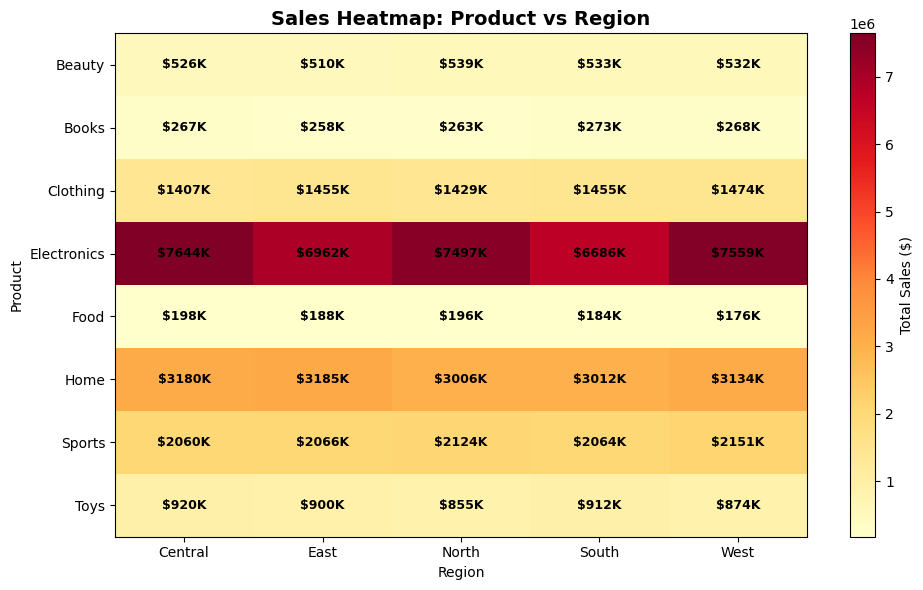

In [12]:
# Create heatmap from pivot table
pivot_heatmap = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Product",
    columns="Region",
    aggfunc="sum",
)

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(pivot_heatmap.values, cmap="YlOrRd", aspect="auto")

# Set ticks and labels
ax.set_xticks(range(len(pivot_heatmap.columns)))
ax.set_yticks(range(len(pivot_heatmap.index)))
ax.set_xticklabels(pivot_heatmap.columns)
ax.set_yticklabels(pivot_heatmap.index)

# Add colorbar
plt.colorbar(im, ax=ax, label="Total Sales ($)")

# Add title and labels
plt.title("Sales Heatmap: Product vs Region", fontsize=14, fontweight="bold")
plt.xlabel("Region")
plt.ylabel("Product")

# Add text annotations
for i in range(len(pivot_heatmap.index)):
    for j in range(len(pivot_heatmap.columns)):
        text = ax.text(
            j,
            i,
            f"${pivot_heatmap.iloc[i, j] / 1000:.0f}K",
            ha="center",
            va="center",
            color="black",
            fontsize=9,
            fontweight="bold",
        )

plt.tight_layout()
plt.show()

### Bar Chart from Pivot Table

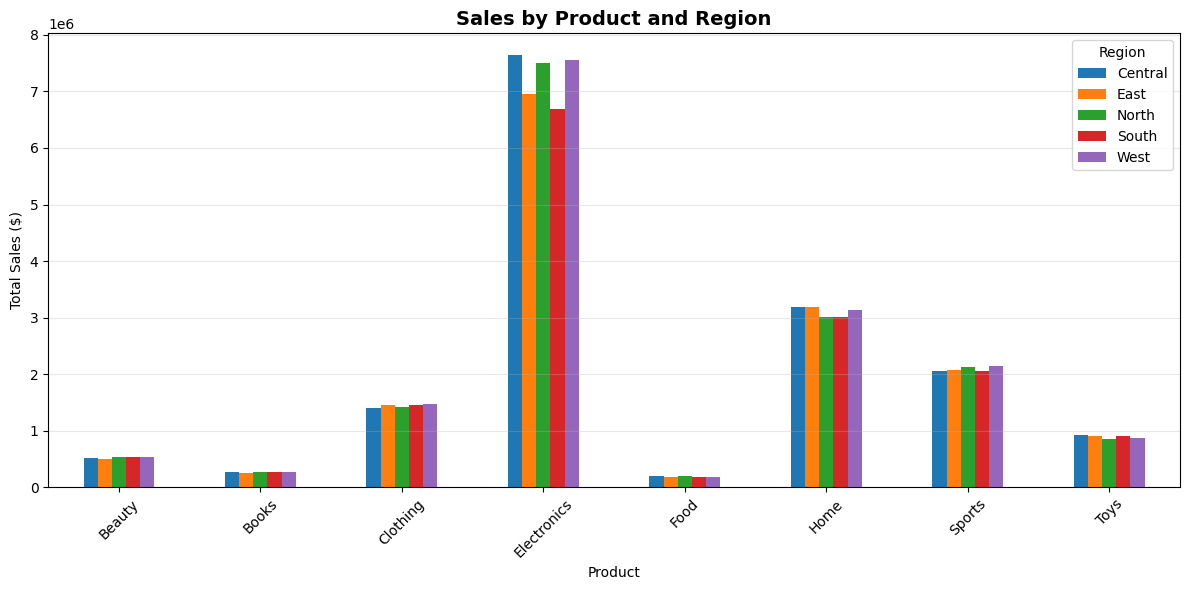

In [13]:
# Create bar chart from pivot table
pivot_bar = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Product",
    columns="Region",
    aggfunc="sum",
)

# Create bar chart
pivot_bar.plot(kind="bar", figsize=(12, 6))
plt.title("Sales by Product and Region", fontsize=14, fontweight="bold")
plt.xlabel("Product")
plt.ylabel("Total Sales ($)")
plt.legend(title="Region")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Part 5: Advanced Pivot Operations

### Custom Aggregation Functions

In [14]:
# Custom aggregation function
def sales_range(series):
    return series.max() - series.min()


# Pivot table with custom function
custom_pivot = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Product",
    columns="Region",
    aggfunc=sales_range,
)
print("=== Custom Aggregation ===")
print("Sales range by product and region:")
print(custom_pivot)

=== Custom Aggregation ===
Sales range by product and region:
Region        Central      East     North     South      West
Product                                                      
Beauty        2099.50   2816.34   2100.76   2043.28   2235.68
Books          949.81   1030.38    957.97    920.17   1053.61
Clothing      5800.12   5390.73   6648.29   5413.21   6249.93
Electronics  24966.05  34239.63  36534.66  21771.14  40328.22
Food           930.59    619.86    775.63    808.42    976.16
Home         11063.58  13044.30  11306.29   8769.68  11622.18
Sports        9829.48   7480.59   8472.72   9794.26  11016.16
Toys          4424.74   6175.41   3027.61   3942.05   3634.00


### Pivot Table with Multiple Values

In [15]:
# Pivot table with multiple value columns
multi_value_pivot = pd.pivot_table(
    sales_df,
    values=["Sales", "Quantity"],
    index="Product",
    columns="Region",
    aggfunc={"Sales": "sum", "Quantity": "mean"},
)
print("=== Multiple Value Columns ===")
print("Sales and quantity by product and region:")
print(multi_value_pivot)

=== Multiple Value Columns ===
Sales and quantity by product and region:
             Quantity                                               Sales  \
Region        Central      East     North     South      West     Central   
Product                                                                     
Beauty       3.093537  3.104490  3.092003  3.077044  3.097630   525916.25   
Books        3.195843  3.044523  3.166667  3.254545  3.081166   267263.61   
Clothing     3.068548  3.043613  3.184959  3.121971  3.077132  1407194.82   
Electronics  3.022770  3.095515  3.136148  3.008024  3.225214  7644269.89   
Food         3.212515  3.164994  3.321498  3.093014  2.932910   197504.53   
Home         3.153098  3.171787  3.176616  2.992718  3.075342  3180482.82   
Sports       3.147239  2.992254  3.161572  3.090391  3.074117  2060143.31   
Toys         3.157255  3.058895  3.106191  3.133333  3.006332   920184.24   

                                                             
Region           

### Reshaping Pivot Results

In [16]:
# Reshape pivot table results
pivot_reshaped = pd.pivot_table(
    sales_df,
    values="Sales",
    index="Product",
    columns="Region",
    aggfunc="sum",
)

# Stack and unstack operations
stacked = pivot_reshaped.stack()
print("=== Reshaping Operations ===")
print("Stacked pivot table:")
print(stacked.head(10))

# Unstack back to wide format
unstacked = stacked.unstack()
print("\nUnstacked back to wide format:")
print(unstacked)

=== Reshaping Operations ===
Stacked pivot table:
Product  Region 
Beauty   Central    525916.25
         East       509666.23
         North      539209.43
         South      532627.74
         West       532420.83
Books    Central    267263.61
         East       258409.81
         North      263170.91
         South      272640.31
         West       267918.07
dtype: float64

Unstacked back to wide format:
Region          Central        East       North       South        West
Product                                                                
Beauty        525916.25   509666.23   539209.43   532627.74   532420.83
Books         267263.61   258409.81   263170.91   272640.31   267918.07
Clothing     1407194.82  1454631.15  1428987.11  1454926.73  1474403.44
Electronics  7644269.89  6962001.12  7496996.51  6685631.56  7558668.85
Food          197504.53   188042.16   196393.60   183640.38   176141.57
Home         3180482.82  3184870.52  3006246.27  3011783.39  3134069.51
Sports    

## Key Takeaways

1. **Pivot Tables**: Transform long-format data to wide-format summaries
2. **Multiple Aggregations**: Use different functions for different insights
3. **Totals and Margins**: Add row and column totals for comprehensive analysis
4. **Missing Values**: Handle missing combinations with fill_value
5. **Cross-Tabulation**: Analyze categorical data relationships
6. **Visualization**: Create heatmaps and charts from pivot tables
7. **Custom Functions**: Apply business-specific aggregation logic

## Next Steps

- Practice with your own datasets
- Experiment with different aggregation functions
- Learn about remote computing for large datasets
- Explore performance optimization techniques